# Diffusion coefficient from a VASP file

Using ``kinisi`` for the analysis of a VASP Xdatcar type file is really straightforward and involves using the ``DiffAnalyzer`` class.

In [1]:
from kinisi.analyze import DiffAnalyzer

There the ``params`` dictionary describes details about the simulation, and are documented in the [parser module](./parser.html).

In [2]:
params = {'specie': 'Li',
          'time_step': 2.0,
          'step_skip': 50,
          'min_obs': 50, 
          'min_dt': 2000}

In [3]:
diff = DiffAnalyzer('example_XDATCAR.gz', params)

Bootstrapping Displacements: 100%|██████████| 120/120 [00:10<00:00, 11.44it/s]


The ``DiffAnalyzer`` will perform the block-bootstrapping process to obtain the displacements and uncertainties, before estimating the correlation matrix betwen the points to sample the diffusion coefficient, $D$.
It is possible to then probe the `D` object itself.

We can get the median and 95 % confidence intervals using, 

In [4]:
diff.D.n, diff.D.con_int

(0.00012682712571032728, array([0.0001031 , 0.00015042]))

We can plot the data and some of the samples from the $D$ and $D_{\text{offset}}$ distribution.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

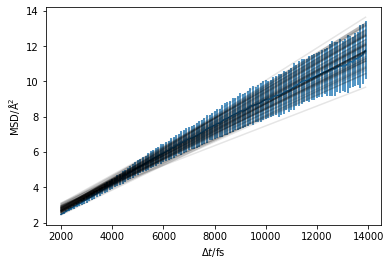

In [6]:
plt.errorbar(diff.dt, diff.msd, diff.msd_err)
for i in np.random.choice(diff.D.size, size=100):
    plt.plot(diff.dt, diff.D.samples[i] * 6 * diff.dt + diff.D_offset.samples[i], 'k', alpha=0.1, zorder=10)
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/fs')
plt.show()

Additionally, we can visualise the distribution of the diffusion coefficient that has been determined, note that we divide by `10` to change units.

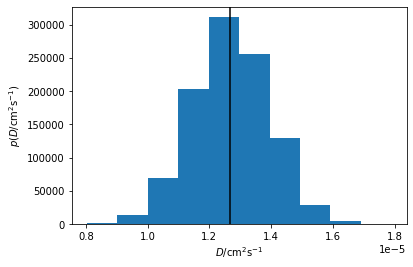

In [7]:
plt.hist(diff.D.samples/10, density=True)
plt.axvline(diff.D.n/10, c='k')
plt.xlabel('$D$/cm$^2$s$^{-1}$')
plt.ylabel('$p(D$/cm$^2$s$^{-1})$')
plt.show()